![Portada](https://i.pinimg.com/originals/aa/fc/95/aafc95cf0bc95a02cc263ca63c388c72.jpg)

With the aid of Bagehot's contributions (The Only Game in Town Links to an external site.), and Copeland & Galai's model (Information Effects on the Bid-Ask Spread Links to an external site.) demonstrated how, even without transaction costs, a spread would exist. This led us to maximize the market maker's profit function in terms of a Bid & Ask price.

### Parameters

1. **Stock Price Follows a Lognormal Distribution:**
   - Distribution: $
   P \sim \text{Lognormal}(60, 2.25)
   $
   - Parameters: $\mu = 60$, $\sigma^2 = 2.25$
   - Description: Indicates that the stock price follows a lognormal distribution with a mean of $60$ and a variance of $2.25$.

2. **Probability of an Informed Trade:**
   - $\Pi_I = 0.4$
   - Description: Represents the probability that a trade is informed, set at $40\%$.

3. **Buy Limit Probability ($\Pi_{LB}$) as a Function of $S$:**
   - $\Pi_{LB}(S) = 0.5 - 0.08S$
   - Constraints: $\Pi_{LB} \in [0, 0.5]$
   - Description: Defines $\Pi_{LB}$, the probability of a buy limit, as a linear function of $S$, where $S = (A - S_0)$, $A$ is the proposed stock price, and $S_0$ is the initial stock price.

4. **Sell Limit Probability ($\Pi_{LS}$) as a Function of $S$:**
   - $\Pi_{LS}(S) = 0.5 - 0.08S$
   - Constraints: $\Pi_{LS} \in [0, 0.5]$
   - Description: Defines $\Pi_{LS}$, the probability of a sell limit, as a linear function of $S$, where $S = (S_0 - B)$, $S_0$ is the initial stock price, and $B$ is the bid price.

5. **Initial Stock Price $S_0$:**
   - $S_0 = 65$
   - Description: Sets the initial stock price at $65$, indicating the price before any trades occur.


Use this wisely:

$$
\begin{aligned}
& \max _{K_A, K_B}\left\{\left(1-p_I\right)\left[p_{B L}\left(K_A-S_0\right)+p_{S L}\left(S_0-K_B\right)\right]\right.
\left.-p_I\left[\int_{K_A}^{\infty}\left(S-K_A\right) f(S) d S+\int_0^{K_B}\left(K_B-S\right) f(S) d S\right]\right\} \geq 0
\end{aligned}
$$

where: 
- $( K_A )$: Proposed selling price or "ask" price.
- $( K_B )$: Proposed buying price or "bid" price.
- $( p_I )$: Probability of an informed trade (( $Pi_I = 0.4 $)).
- $( p_{LB} )$: Buy limit probability as a function of $( S )$ ($( \Pi_{LB}(S) $)).
- $( p_{LS} )$: Sell limit probability as a function of $( S $) ($( \Pi_{LS}(S) $)).
- $( S_0 )$: Initial stock price (65).
- $( S )$: Stock price, which follows a lognormal distribution with $( \mu = 60 )$ and $( \sigma^2 = 2.25 )$.
- $( f(S) )$: The probability density function of the lognormal distribution of stock prices.


---

A Jupyter notebook containing:
- Plot the price distribution.

Create a plot showing:
- Expected revenue if all trades are liquidity trades, and $\Pi_{LB} = \Pi_{LS} = 0.5$.
- Expected revenue if there is a 40% chance that an informed trade will be executed, keep the same liquidity probabilities as the previous point.
- Expected revenue considering:
  - $\Pi_I = 0.4$
  - $\Pi_{LB}(S) = 0.5 - 0.08S$ where $\Pi_{LB}: [0, 0.5]$
  - $\Pi_{LS}(S) = 0.5 - 0.08S$ where $\Pi_{LS}: [0, 0.5]$

Determine the optimal Bid / Ask price using Copeland & Galai's model with the defined parameters.


---

In [1]:
from sympy import integrate, init_printing as sp
from sympy.abc import x as xsp
import scipy.stats as st
import scipy.optimize as opt
import tqdm
from scipy.integrate import quad
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.optimize import minimize
from scipy.stats import lognorm
from scipy.integrate import quad

### <font color="darkblue">Distribution's price plot</font>

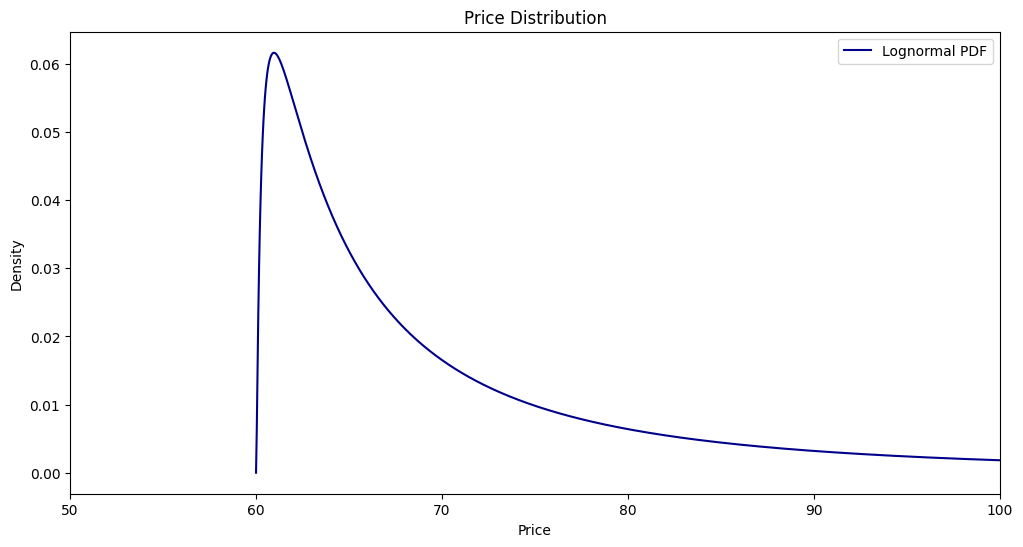

In [10]:
# Define the mean and standard deviation for the lognormal distribution
mu = 60
sigma = np.sqrt(2.25)

# Generate a random sample of prices from the lognormal distribution
P = np.random.lognormal(np.log(mu), sigma, size=100)

# Create an array of values for plotting the PDF
x = np.linspace(60.0001, 100, 1000)

# Define the probability density function (PDF) for the lognormal distribution
y = lambda x: (1 / x * sigma * (2*np.pi)**(1/2)) * np.exp(-((np.log(x-mu))**2/(2*sigma**2)))

# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Plot the lognormal PDF
plt.plot(x, y(x), color='darkblue', label='Lognormal PDF')

# Set the title and axis labels for the plot
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')

# Set the limits for the x-axis
plt.xlim(50, 100)

# Add legend to the plot
plt.grid(False)
plt.legend()

**Analysis:**
In the graph, we can observe that the prices follow a **lognormal distribution**, indicating that the values are asymmetrically distributed, with a higher concentration of lower prices and a decreasing probability of encountering higher prices. The mean of this distribution is 60, and the variance approximately 2.25, suggesting a moderate spread around the mean.

---

### <font color="darkblue"> Determining Optimal Bid/Ask Prices with Copeland & Galai's Model: A Parameter-Driven Approach</font>

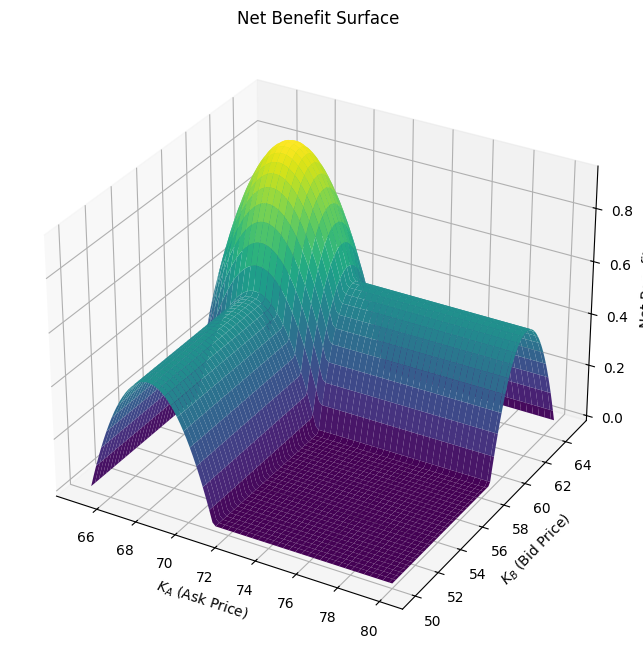

In [11]:
# Define the scale parameter using the exponential of the mean
scale = np.exp(mu)

# Define the probability of informed trading and initial stock price
pi_I = 0.4
S_0 = 65

# Define the probability density function for the lognormal distribution
def lognorm_pdf(x):
    return lognorm.pdf(x, s=sigma, scale=scale)

# Functions for liquidity benefits, adjusted for the range [0, 0.5]
def pi_LB(K_A):
    return max(0, min(0.5, 0.5 - 0.08 * (K_A - S_0)))

def pi_LS(K_B):
    return max(0, min(0.5, 0.5 - 0.08 * (S_0 - K_B)))

def objective_function(K):
    K_A, K_B = K  #
    income = (1 - pi_I) * (pi_LB(K_A) * (K_A - S_0) + pi_LS(K_B) * (S_0 - K_B))

    # Calculate the integral above K_A and below K_B
    integral_above_K_A, _ = quad(lambda S: (S - K_A) * lognorm_pdf(S), K_A, np.inf)
    integral_below_K_B, _ = quad(lambda S: (K_B - S) * lognorm_pdf(S), 0, K_B)
    cost = pi_I * (integral_above_K_A + integral_below_K_B)

    return -(income - cost)

# Define the range of values for K_A and K_B
K_A_values = np.linspace(S_0, S_0 + 10*sigma, 100)
K_B_values = np.linspace(S_0 - 10*sigma, S_0, 100)

# Calculate the net benefit for each combination of K_A and K_B
benefit_surface = np.zeros((len(K_A_values), len(K_B_values)))

for i, K_A in enumerate(K_A_values):
    for j, K_B in enumerate(K_B_values):
        benefit_surface[i, j] = -objective_function([K_A, K_B])  

# Plot the net benefit surface
KA_grid, KB_grid = np.meshgrid(K_A_values, K_B_values, indexing='ij')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(KA_grid, KB_grid, benefit_surface, cmap='viridis')

ax.set_xlabel('$K_A$ (Ask Price)')
ax.set_ylabel('$K_B$ (Bid Price)')
ax.set_zlabel('Net Benefit')
ax.set_title('Net Benefit Surface')
plt.show()

In [4]:
# Set initial guess and bounds for optimization
initial_guess = [S_0+ sigma, S_0 - sigma]
bounds = [(S_0, None), (S_0-10*sigma , S_0)] 

In [5]:
# Perform optimization
result = minimize(objective_function, initial_guess, bounds=bounds)
# Extract bid and ask prices from optimization result
bid = result.x[1]  
ask = result.x[0]
print(f'Optimization result: expected revenue {round(-result.fun, 4)}, with a Bid of ${round(bid, 2)} y an Ask of ${round(ask,2)}')

Optimization result: expected revenue 0.9375, with a Bid of $61.88 y an Ask of $68.13


**Analysis:** The 3D plot visualizes the net benefit for market makers based on varying ask and bid prices under a lognormal price distribution. The surface indicates how the net benefit changes with price decisions, taking into account liquidity benefits and the probability of informed trading. Optimal ask and bid prices are identified to maximize net benefit, resulting in an expected revenue of  0.9375 with optimal ask and bid prices at approximately 68.13 and 61.88, respectively.

| Metric             | Value   |
|--------------------|---------|
| Expected Revenue   | 0.9375 |
| Optimal Bid Price  | 61.88  |
| Optimal Ask Price  |68.13  |


---


### <font color="darkblue"> Create a plot showing:</font>
1.  Expected revenue if all trades are **liquidity** trades, and $\Pi_{LB} = \Pi_{LS} = 0.5$

2. Expected revenue if there is a $40%$ chance that an **informed** trade will be executed, keep the same liquidity probabilities as the previous point. 

3. Expected revenue considering:
      - $\Pi_I = 0.4$
      - $\Pi_{LB} (S) = 0.5 - 0.08S$ where  $\Pi_{LB} : [0, 0.5]$
      - $\Pi_{LS} (S) = 0.5 - 0.08 S$ where $\Pi_{LS} : [0, 0.5]$
     

**Scenarios:**

1. **Liquidity Trades Revenue**:
   - All trades are assumed to be liquidity trades.
   - Fixed liquidity benefits with ( $Pi_{LB} = \Pi_{LS} = 0.5 $).
   - Revenue is constant and equal to the spread.
   


2. **Informed Trades Revenue**:
   - There is a 40% chance of trades being informed.
   - Liquidity benefits are the same as in the first scenario.
   - Expected revenue is reduced by the probability of informed trading ( $Pi_I $).


3. **Variable Liquidity and Informed Trades Revenue**:
   - Informed trade probability is ( $Pi_I = 0.4 $).
   - Liquidity benefits decrease with the spread size.
   - ( $Pi_{LB} (S) $) and ( $Pi_{LS} (S) $) range from 0 to 0.5 and decrease by 0.08 for each unit increase in spread.


Text(0, 0.5, 'Revenue')

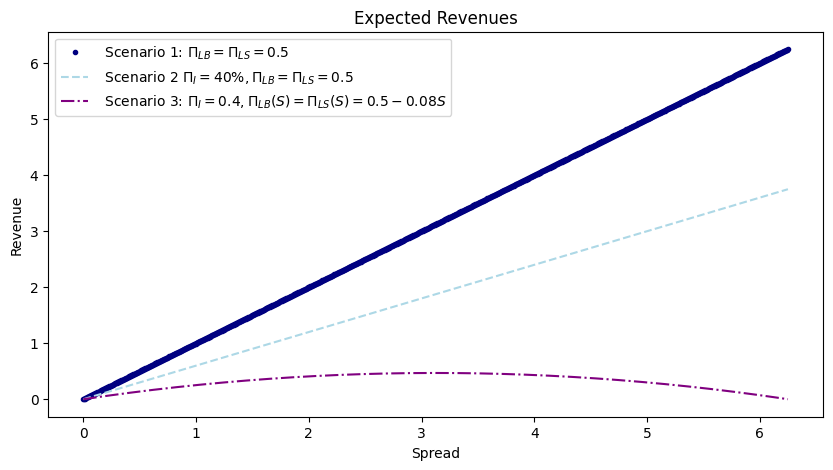

In [22]:
# Generate spreads
spreads = np.linspace(0, ask - bid, 1000)

# Calculate expected revenues for different scenarios
liq_trades = spreads
inf_trades = spreads * (1 - pi_I)
trades3 = list(map(lambda x: (0.5 - 0.08*x) * (1 - pi_I) * x, spreads))

# Plot expected revenues
plt.figure(figsize=(10, 5))

plt.plot(spreads, liq_trades, '.',  color='navy', label=' Scenario 1: $ \Pi_{LB} = \Pi_{LS} = 0.5 $')
plt.plot(spreads, inf_trades, '--', color='lightblue', label=' Scenario 2 $ \Pi_{I} = 40 \% , \Pi_{LB} = \Pi_{LS} = 0.5 $')
plt.plot(spreads, trades3,'-.', color='purple', label=' Scenario 3: $ \Pi_{I} = 0.4 , \Pi_{LB}(S) = \Pi_{LS}(S) = 0.5 - 0.08 S $')
plt.legend(loc='best')

plt.title('Expected Revenues')
plt.xlabel('Spread')
plt.ylabel('Revenue')


**Analysis by Scenario**

##### Scenario 1: Liquidity Trades
- The plot shows that the revenue increases linearly with the spread, suggesting that the market maker's income is directly proportional to the spread. This is the most straightforward scenario, with no influence from informed traders.

##### Scenario 2: Informed Trades
- Here, there's a 40% chance of encountering an informed trade, while liquidity benefits remain the same as in Scenario 1. The expected revenue, represented by the dashed line, is lower than in Scenario 1 and increases with the spread, but at a diminished rate. This reduction reflects the risk of trading with informed traders, who are more likely to trade when it's disadvantageous to the market maker.

##### Scenario 3: Variable Liquidity Benefits and Informed Trades
- The purple line indicates that revenues are highest for small spreads but increase at a much slower pace compared to Scenario 1. This is due to the decreasing liquidity benefit as the spread increases, highlighting the trade-off between spread size and liquidity benefits in a market with a significant proportion of informed trading.


---